# Adversarial Attacks with Carlini & Wagner Approach
## Introduction

Quellen:  
- https://medium.com/@zachariaharungeorge/adversarial-attacks-with-carlini-wagner-approach-8307daa9a503   
- https://arxiv.org/pdf/1608.04644.pdf

Der Carlini & Wagner Attacke ist eine Methode, um Deep Learning Modelle anzugreifen. Der Carlini & Wagner Attacke kann als Optimierungsproblem betrachtet werden, bei dem der Input so minimal wie möglich verändert wird, dass eine maximale Fehlklassifkation erreicht wird. Die Attacke wird oft als Benchmark für Adverserial Attacks bei unterschiedlichen Modellen verwendet und wird als state-of-the-art Attacke betrachtet.

Das Optimierungsproblem kann dabei wie folgt formuliert werden:

$$
J(X') = \alpha * dist(x, x') + \beta * loss(f(x'), y_t)
$$

Wobei folgende Notationen verwendet werden:
- x: Originaler Input
- x': Veränderter Input
- dist(x, x'): Distanz zwischen x und x', kann z.B. L2-Norm oder L-Infinity-Norm (L-max-Norm) sein. Sagt aus, wie stark der Input verändert wird. ()
- f(x', y_t): Klassifizierungsfehler des Modells, wenn x' als Input verwendet wird. y_t ist die Zielklasse, die erreicht werden soll.
- alpha, beta: Gewichtungen, um die beiden Ziele zu balancieren.

Betrachten wir die Formel so sehen wir, dass wir zwei unterschiedliche Ziele verfolgen. Einerseits wollen wir die Distanz zwischen x und x' minimieren, andererseits wollen wir den Klassifizierungsfehler maximieren. Die Gewichtungen alpha und beta helfen uns dabei, die beiden Ziele zu balancieren.

In [2]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninsta

In [3]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

import torch.optim as optim

from torchvision import datasets, transforms
from torchattacks import CW

import torchvision.models as models



## Models

In [4]:
# Load pretrained AlexNet
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# freeze the weights
for param in alexnet.parameters():
    param.requires_grad = False

# modify the last layer
alexnet.classifier[6] = nn.Linear(4096, 10)

print(alexnet)

model = alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 161MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Dataset

In [5]:
# Load MNIST dataset
transform = transforms.Compose([transforms.Resize((224, 224)),  # Resize to match AlexNet's expected input size
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:13<00:00, 12899562.39it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
from tqdm import tqdm

correct = 0
total = 0

# Wrap your test_loader with tqdm
for inputs, labels in tqdm(test_loader, desc="Testing Progress", unit="batch"):
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Original Model Accuracy: {accuracy}")

Testing Progress: 100%|██████████| 157/157 [03:35<00:00,  1.37s/batch]

Original Model Accuracy: 0.1373


In [7]:
# Create a CW attack object
attack = CW(model, c=1e-4, lr=0.01)

# Generate adversarial examples
inputs, labels = next(iter(test_loader))
adv_examples = attack(inputs, labels)

# Evaluate the model on adversarial examples
with torch.no_grad():
    adv_outputs = model(adv_examples)
    _, adv_predicted = torch.max(adv_outputs.data, 1)
    adv_correct = (adv_predicted == labels).sum().item()

adv_accuracy = adv_correct / total
print(f"Model Accuracy on Adversarial Examples: {adv_accuracy}")

Model Accuracy on Adversarial Examples: 0.0007


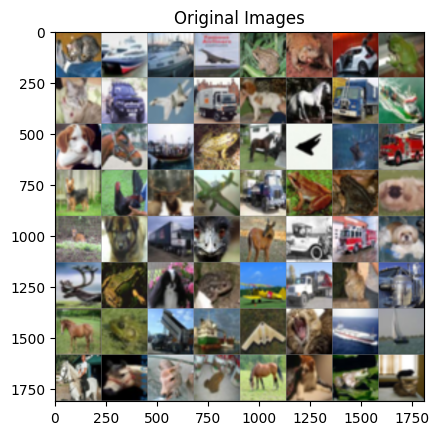

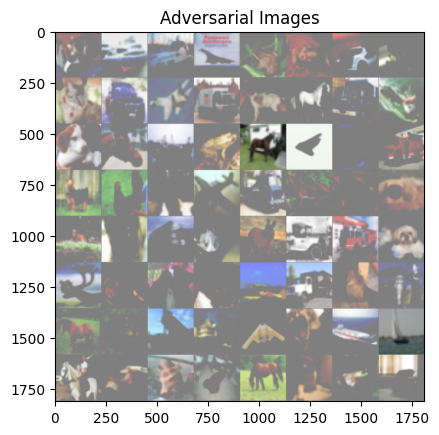

In [8]:
# Visualize the original and adversarial examples
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Display original images
imshow(torchvision.utils.make_grid(inputs), "Original Images")

# Display adversarial images
imshow(torchvision.utils.make_grid(adv_examples.detach()), "Adversarial Images")